In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [2]:
#Size of our input images
SIZE = 128

# Setting the training and testing datasets 

ImageDataGenerator.flow_from_directory: Takes the path to a directory and generates batches of augmented data.

In [4]:
batch_size = 64
datagen = ImageDataGenerator(rescale=1./255) # Typically used for data augmentation. Here it is only rescaling the image pixels value to range 0 to 1 in decimals

train_generator = datagen.flow_from_directory(
    # "../../Images/BottleStoodUp_atNight/Positive/",
    "../../../BottleStoodUp_atNight/Positive/",
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'          # Class used for working with Autoencoders
    )

Found 179 images belonging to 1 classes.


In [5]:
validation_generator = datagen.flow_from_directory(
    "../../../BottleStoodUp_atNight/Positive_val/",
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )


Found 30 images belonging to 1 classes.


In [6]:
anomaly_generator = datagen.flow_from_directory(
    "../../../BottleStoodUp_atNight/Anomalies/",
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )


Found 6 images belonging to 1 classes.


# Configuring the Autoencoder netwrok

In [7]:
#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

See that above, the training of the model is stopped because the trainig generator did not provide the minimum number of batches for it to be trained. According to the message displayed above, the model expects at least 1400 batches.

Let's try another configuration for the model training. Here, we don't specify the steps per epoch. Resulting in a three-step long epoch, because the entire training model contains 3 batches.

Loading the model that was previously saved


In [8]:
model = keras.models.load_model('../models/BottlesModel1')
print(type(model))

<class 'keras.engine.sequential.Sequential'>


Get all batches generated by the datagen and pick a batch for prediction

In [9]:
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
# while img_num <= len(train_generator):        #I think this should be the correct while clause
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1
    
print("number of batches are: ", img_num)


number of batches are:  3


Predict on the first batch of images. Do also notice that the prediction is being carried out over the images we used for training.

In [10]:
print(data_batch[0].shape)
predicted = model.predict(data_batch[0])  
print(predicted.shape)

(64, 128, 128, 3)
2/2 [==============================] - 1s 166ms/step
(64, 128, 128, 3)


The above is 64 length because it corresponds to the 64 predicted images of a batch. Recall that the predictions are reconstructions of the input images, since we are working with the autoencoder network.

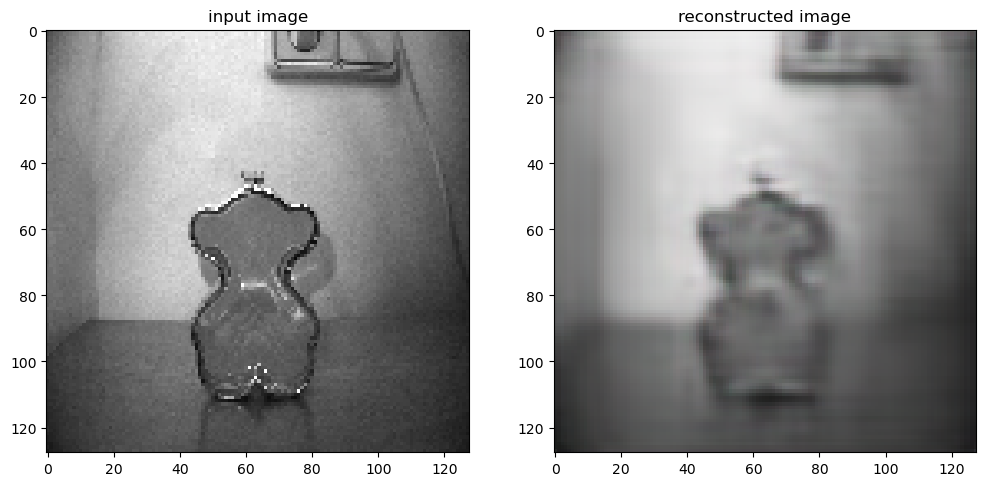

In [11]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(predicted[image_number])
plt.show()

As it can be seen above, the reconstruction is not that good, it is very blurry. However, we can see to generate negative artificial samples and see if these are capable of being detected as such.

Let us examine the reconstruction error between our validation data (good/normal images) and the anomaly images

In [12]:
validation_error = model.evaluate_generator(validation_generator)
print("Recon. error for the validation (normal) data is: ", validation_error)

C:\Users\Alex\AppData\Local\Temp\ipykernel_19268\2207300971.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  validation_error = model.evaluate_generator(validation_generator)


Recon. error for the validation (normal) data is:  [0.002775531029328704, 0.002775531029328704]


Here above we see a vector with two components which happen to be the same between them. This is because in the model, when we define the outputs, the loss function type and the metric are the same parameter, the mse (mean square error).

This reconstruction error above should be very low, since the validation generator is full of normal images (good images)

Whereas the reconstruction error here below, for the "anomaly_generator" should be higher, since this dataset is comprised of full anomaly images.

In [13]:
anomaly_error = model.evaluate_generator(anomaly_generator)
print("Recon. error for the anomaly data is: ", anomaly_error)

C:\Users\Alex\AppData\Local\Temp\ipykernel_19268\4089772597.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  anomaly_error = model.evaluate_generator(anomaly_generator)


Recon. error for the anomaly data is:  [0.0028120651841163635, 0.0028120651841163635]


See that this error is slightly higher than the error in the validation dataset. This is good, but the difference is not that significant and this could result in wrong anomaly detections. Let's see some detections.

The following function performs:
- Initialize a vector for storing the reconstruction errors.
- A for loop that traverses all the images contained in a batch.
    - Take the one image of the batch.
    - Add a new size dimension to the image.
    - Make a prediction of the selected image with the model that was built.
    - Evaluate the performance of the prediction, i.e. compute the prediction error.
    - Append the reconstruction error into a list.
- Compute the mean and std deviation of the error.
 

In [14]:
def calc_recon_error(batch_images):   
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        recon_error_list.append(reconstruction_error)   
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_recon_error, stdev_recon_error

Compute the average and std dev. of recon. error for positive (anomalies) and negative samples. 
For this let us generate a batch of images for each. 

Make sure the first batch is selected for both, train and anomaly batches. For the anomalies case, notice that is not important to check this, since the anomaly dataset contains one batch only. For the train batch make sure to execute the below code block until the batch index is at 2, so that the next execution will select the batch index number 0.

In [20]:
while (train_generator.batch_index != 2):
    train_batch = train_generator.next()
    print(train_generator.batch_index)

1
2


In [19]:
anomaly_batch = anomaly_generator.next()
print(anomaly_generator.batch_index)

0


In [22]:
train_batch = train_generator.next()[0]     # This is the uninfected images
anomaly_batch = anomaly_generator.next()[0] # This is the parasitized images

good_samples_values = calc_recon_error(train_batch)
anomaly_values = calc_recon_error(anomaly_batch)

1/1 [==============================] - 0s 30ms/step - loss: 0.0056 - mse: 0.0056


In [23]:
print("The mean reconstruction error value for the good samples is: ", good_samples_values[0], " with std deviation of: ", good_samples_values[1])
print("The mean reconstruction error value for the anomalies samples is: ", anomaly_values[0], " with std deviation of: ", anomaly_values[1])


The mean reconstruction error value for the good samples is:  0.00590768126770854  with std deviation of:  0.0004474858146121657
The mean reconstruction error value for the anomalies samples is:  0.006076302472501993  with std deviation of:  0.0006649333056199273


Based on the information shown above, we can set a threshold for discriminating good samples from anomalies ones. 

The following function does:
- Sets the reconstruction error threshold.
- Opens the given image path.
- Resizes the image 
- Depending on the image size it adds a dimension to it. The image must be at the end of this of 3 dimensions in size.
- Converts the image pixel values to float numbers, ranging from 0 to 1. 
- Adds a fourth dimension to the image.
- Performs a prediction using the model and a given image.
- Computes the prediction error.
- Depending on the prediction error it prints the message to whether the image is an anomaly or not. 

In [24]:
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    reconstruction_error_threshold = 0.006 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    image_shape = img.shape
    if(len(image_shape)==2):
        img = np.dstack((img, img, img))
    plt.imshow(img)
    img = img / 255.
    print(img.shape)
    img = img[np.newaxis, :,:,:]
    
    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if reconstruction_error > reconstruction_error_threshold:
        print("The image IS an anomaly") 
    else:
        print("The image is NOT an anomaly")

In [25]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
anomaly_file_paths = glob.glob(r'C:\Users\Alex\Documents\BottleStoodUp_atNight\Anomalies\Anomalies_samples\*')
positive_file_paths = glob.glob(r'C:\Users\Alex\Documents\BottleStoodUp_atNight\Positive\Positive_samples\*')

Checking the anomalies

(128, 128, 3)
1/1 [==============================] - 0s 35ms/step - loss: 0.0061 - mse: 0.0061


C:\Users\Alex\AppData\Local\Temp\ipykernel_19268\3962754466.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


The image IS an anomaly
This image directory is:  C:\Users\Alex\Documents\BottleStoodUp_atNight\Anomalies\Anomalies_samples\img1.jpg


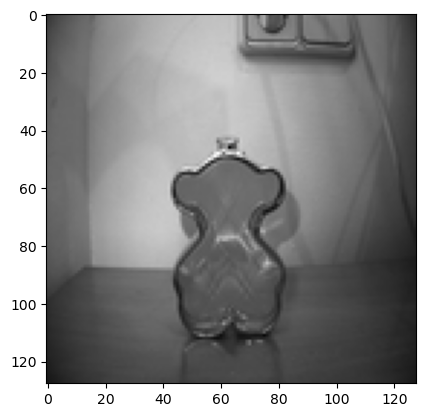

In [30]:
num=random.randint(0,len(anomaly_file_paths)-1)
check_anomaly(anomaly_file_paths[num])
print("This image directory is: ", anomaly_file_paths[num])

Checking the positive samples, these are NOT supposed to be anomalies.

(128, 128, 3)
1/1 [==============================] - 0s 50ms/step - loss: 0.0049 - mse: 0.0049


C:\Users\Alex\AppData\Local\Temp\ipykernel_19268\3962754466.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


The image is NOT an anomaly
This image directory is:  C:\Users\Alex\Documents\BottleStoodUp_atNight\Positive\Positive_samples\07-03-2023 - 22.59.39_5.bmp


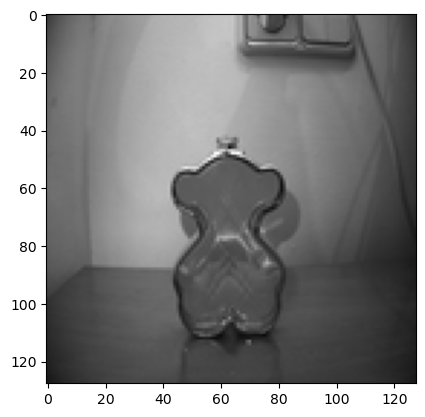

In [27]:
num=random.randint(0,len(positive_file_paths)-1)
check_anomaly(positive_file_paths[num])
print("This image directory is: ", positive_file_paths[num])

From the specific tests above, the model has succesfully discriminated negative samples from the positive ones. However, varifying various images, it was seen that the performance is poor. Next we will label the images so that we can better analyze the results of all of them.

# Labeling the images

Creating the anomalies samples with their correspondant labels

In [31]:
anomalies_labels = np.ones(6)
print(anomalies_labels)

[1. 1. 1. 1. 1. 1.]


In [32]:
anomalies_samples = (anomaly_file_paths,anomalies_labels)

In [33]:
print("These are the anomalies links: ", anomalies_samples[0])
print("These are the anomalies labels: ", anomalies_samples[1])

These are the anomalies links:  ['C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Anomalies\\Anomalies_samples\\img1.jpg', 'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Anomalies\\Anomalies_samples\\img2.jpg', 'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Anomalies\\Anomalies_samples\\img3.jpg', 'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Anomalies\\Anomalies_samples\\img4.jpg', 'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Anomalies\\Anomalies_samples\\img5.jpg', 'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Anomalies\\Anomalies_samples\\img6.jpg']
These are the anomalies labels:  [1. 1. 1. 1. 1. 1.]


Creating the positive samples with their correspondant labels

In [34]:
positive_labels = np.zeros(len(positive_file_paths))
print(positive_labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [35]:
positive_samples = (positive_file_paths,positive_labels)
print("These are the positive links: ", positive_samples[0])
print("These are the positive labels: ", positive_samples[1])

These are the positive links:  ['C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.28.40_0.bmp', 'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.28.40_1.bmp', 'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.28.40_10.bmp', 'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.28.40_11.bmp', 'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.28.40_12.bmp', 'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.28.40_13.bmp', 'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.28.40_14.bmp', 'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.28.40_15.bmp', 'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07

Creating a new function baed on "check_anomaly()" that outputs directly the predicted label of the given image. This function is called predict_label()

In [36]:
def predict_label(img_path):
    reconstruction_error_threshold = 0.006
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    image_shape = img.shape
    if(len(image_shape)==2):
        img = np.dstack((img, img, img))
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
    if reconstruction_error > reconstruction_error_threshold:
        prediction = 1 
    else:
        prediction = 0
    return prediction

In [37]:
num=random.randint(0,len(positive_file_paths)-1)
model_prediction = predict_label(positive_samples[0][num])
model_label = int(positive_samples[1][num])
print("The model predicts that the given image is: ", model_prediction)
print("The original label of the given image is: ", model_label)

1/1 [==============================] - 0s 38ms/step - loss: 0.0061 - mse: 0.0061
The model predicts that the given image is:  1
The original label of the given image is:  0


C:\Users\Alex\AppData\Local\Temp\ipykernel_19268\2248361421.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


# Using some metrics for evaluating model predictions

In [38]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity
from sklearn.metrics import f1_score

## Using the positive samples set. All images are NON-ANOMALIES bottles

We will see first, the precision of the training dataset, which consists on full positive images, i.e. image of bottles without anomalies, their labels are full zeros. 

In [39]:
positive_samples

(['C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.28.40_0.bmp',
  'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.28.40_1.bmp',
  'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.28.40_10.bmp',
  'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.28.40_11.bmp',
  'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.28.40_12.bmp',
  'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.28.40_13.bmp',
  'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.28.40_14.bmp',
  'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.28.40_15.bmp',
  'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Positive\\Positive_samples\\07-03-2023 - 22.

In [40]:
print(len(positive_samples[1]))

179


In [41]:
predictions_list = [] 
labels_list = [] 
for i in range(len(positive_file_paths)-1):
    model_prediction = predict_label(positive_samples[0][i])
    model_label = int(positive_samples[1][i])
    predictions_list.append(model_prediction)  
    labels_list.append(model_label)

1/1 [==============================] - 0s 34ms/step - loss: 0.0073 - mse: 0.0073


C:\Users\Alex\AppData\Local\Temp\ipykernel_19268\2248361421.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0058 - mse: 0.0058


In [42]:
print(predictions_list)

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]


### The Precision metric

In [40]:
pre = Precision()

This metric simply divides true_positives by the sum of true_positives and false_positives.

In [41]:
pre = Precision()
pre.update_state([0, 1, 1, 1], [1, 0, 1, 1])
pre.result().numpy()

0.6666667

See above that:
- Number of true positives elemnts: 2. The last two "1"s of the second vector.
- Number of false positives: 1. The first "1" of the second vector. 

Then, the precision value of this prediction is: 

= 2/(2+1)

= 0.66667

Below, we have another example of the Precision function. This time it is using the "sample_weight" parameter. This is a mask, wherever there is a "1" the precision metric will be computed.

In [42]:
pre.reset_state()
pre.update_state([0, 1, 1, 1], [1, 0, 1, 1], sample_weight=[1, 1, 1, 0])
pre.result().numpy()

0.5

A final test of the Precision metric before applying it to the real data we are working with.

Notice this case below. The ground truth, the first vector is telling us that there ALL of these samples are positive, i.e. these are normal bottles, bottles without any anomalies.

In [43]:
pre.reset_state()
pre.update_state([0, 0, 0, 0], [1, 0, 0, 1])
pre.result().numpy()

0.0

And the precision value is zero. This is because:
- True positives = 0 
- False positives = 2

Then Precision = 0/(0+2) = 0

Interpreting this result: From all the samples that the model predicted to be anomaly bottles, all of them are wrong predictions. This is because we know that all the bottles were in reality, positive samples, not anomalies at all. 

Let's see the effect of fliping the values of the vectors. Do we arrive to the same conclusion?

In [44]:
pre.reset_state()
pre.update_state([1 ,1 ,1, 1], [0, 1, 1, 0])
pre.result().numpy()

1.0

Now, the precision value is 1. Since:
- True positives = 2
- False positives = 0

Then Precision = 2/(2+0) = 1

This can be interpreted as: Since we have flipped the values, now 0 stands for bottles WITH anomalies and 1 stands for bottles WITHOUT anomalies. Hence, the model has 100% precision at the moment of predicting bottles WITHOUT anomalies. From all the bottles that the model predicted were bottles without anomalies (two bottles), all of them were correct predictions. 

From the tests above, it is clear that we want to see the precision of the model at the moment of predicting bottles WITH anomalies, hence we do:

In [45]:
pre.reset_state()
pre.update_state(labels_list, predictions_list)
pre.result().numpy()

0.0

In [46]:
print(predictions_list)

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]


As it can be seen the precision is 0%. That is because the model has predicted that some of the bottles DO HAVE anomalies where we know that in reality none of the bottles have any anomaly. 

It is also important to highlight that the optimal case would have been for example:

Ground truth: [0,0,0,0]
Predicted labels: [0,0,0,0]

True positives = 0
False positives = 0
Precision = 0/(0+0) = 0

Leading us to the conclusion that given this case, where all the samples of the ground truth are NOT anomaly bottles, the precision metric by its own might not be enough for explaining the truth performance of the model. 

In [47]:
pre.reset_state()
pre.update_state([0,0,0,0], [0, 0, 0, 0])
pre.result().numpy()

0.0

### The Recall metric

In [48]:
re = Recall()

The recall metric tells us: out of all the positive examples, how many were predicted as positive? This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

Remember we still working the dataset of full positive samples, i.e. bottles WITHOUT anomalies.

In [49]:
re.update_state([0,1,1,0], [1, 0, 1, 0])
re.result().numpy()

0.5

See above that:
- Number of true positives elemnts: 1. The "1" of the third position of the second vector.
- Number of false negatives: 1. The "0" of the second position of the second vector. 

Then, the recall value of this prediction is: 

= 1/(1+1)

= 0.5

See this other example. Since we do not have any true positive, the recall metric will remain zero.

In [50]:
re.reset_state()
re.update_state([0,0,0,0], [0,0,1,0])
re.result().numpy()

0.0

Flipping the values. Now the ANOMALIES bottles are represented by 0 and the NO-ANOMALIES bottles are represented by 1

In [51]:
re.reset_state()
re.update_state([1,1,1,1], [1,1,0,1])
re.result().numpy()

0.75

See above that:
- Number of true positives elemnts: 3.
- Number of false negatives: 1. 

Recall = 3 / (3+1) = 0.75

We have a recall of 75% of detecting bottles WITHOUT anomalies.

Let's now check with the dataset of this project.

In [52]:
re.reset_state()
re.update_state(labels_list, predictions_list)
re.result().numpy()

0.0

In [53]:
print(predictions_list)

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]


Since we do not have any true positive the recall value is still 0 for this case. 

And it happens the same as in the Precision metric. See the example below:

In [54]:
re.reset_state()
re.update_state([0,0,0,0], [0,0,0,0])
re.result().numpy()

0.0

Above is shown a fully correct prediction. But still the recall value is zero. This is because no positive sample is present in the ground truth.

### The Specificity metric

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

Specificity = (tn / (tn + fp))

As we are working in here with full NOes, that is bottles WITHOUT anomalies, perhaps this would be a good metric for this case.

In [55]:
spec = SpecificityAtSensitivity(0.5)  # Not completely sure why to input 0.5 for specificity computation

In [56]:
spec.update_state([0,1,1,0], [1, 0, 1, 0])
spec.result().numpy()

0.5

The examples above consists on:
- True negative detections: 1.
- False positive detections: 1.

Specificity = 1/(1+1) = 0.5

But it does not work very well with other examples. See:

In [57]:
spec.reset_state()
spec.update_state([0,0,0,0], [0,1,0,0])
spec.result().numpy()

0.0

The above result should be:
- True negative detections: 3.
- False positive detections: 1.

Specificity = 3/(3+1) = 0.75

Hence, for the moment the computation of the specificity will be made with an alternative function.

#### Trying the sklearn library for specificity

In [58]:
from sklearn.metrics import confusion_matrix
import math

tn, fp, fn, tp = confusion_matrix([0,1,1,0], [1, 0, 1, 0]).ravel()
specificity_val = tn/(tn+fp)
if(math.isnan(specificity_val)):
    specificity_val = 0
print("The specificity value is: ", specificity_val)


The specificity value is:  0.5


Above works according to the expected. See another example:

In [59]:
tn, fp, fn, tp = confusion_matrix([0,0,0,0], [0,1,0,0]).ravel()
specificity_val = tn/(tn+fp)
if(math.isnan(specificity_val)):
    specificity_val = 0
print("The specificity value is: ", specificity_val)

The specificity value is:  0.75


Above as well, it is the expected specificity value. Now try with the actual data of the project.

In [60]:
tn, fp, fn, tp = confusion_matrix(labels_list, predictions_list).ravel()
specificity_val = tn/(tn+fp)
if(math.isnan(specificity_val)):
    specificity_val = 0
print("The specificity value is: ", specificity_val)

The specificity value is:  0.5393258426966292


The model has 53.93% of specificity metric detection. This means that, when it comes to detect normal bottles, that is, bottles without anomalies, the model performs it well in 53.93% of the predicitons.

### The Accuracy metric

In [61]:
acc = BinaryAccuracy()

Compute the frequency with which y_pred matches y_true.

In [62]:
acc.update_state([0,1,1,0], [1, 0, 1, 0])
acc.result().numpy()

0.5

Above we can see:
- The last two numbers match values.
- There are four numbers in total.

Accuracy = 2/4 = 0.5

Applying this to the dataset we are working with:

In [63]:
acc.reset_state()
acc.update_state(labels_list, predictions_list)
acc.result().numpy()

0.53932583

It outputs a 53.93% of accuracy.

### The Confusion Matrix

In [64]:
from sklearn.metrics import confusion_matrix

Having the predicted and true labels we can generate the confustion matrix. 

In [65]:

# result = confusion_matrix(labels_list, predictions_list,normalize='pred') #Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(labels_list, predictions_list)
print(result)

[[96 82]
 [ 0  0]]


Now, to plot the confusion matrix in a very comprehensive way, we use:

In [66]:
import seaborn as sn
import pandas as pd

Text(0.5, 23.52222222222222, 'Predicted label')

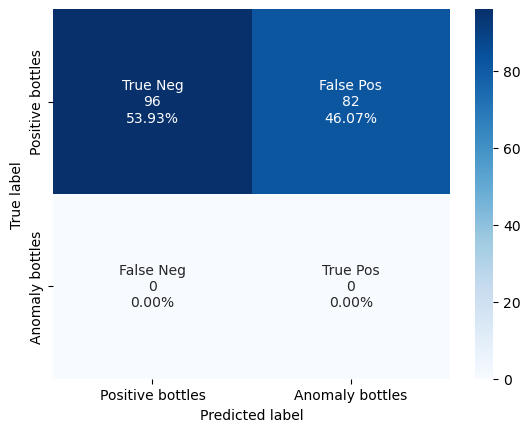

In [67]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     result.flatten()/np.sum(result)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 
# labels = [f"{v1}\n{v2}" for v1, v2 in
#           zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(result, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

From above, we can see that the model correctly classifies the positive samples, that is, the bottles without anomalies (96 correctly classified). On the other hand, the classifications for anomaly bottles, the model incorrectly classifies 82 samples as anomalies when it should be positive samples.

### The F1 score

This metric is used for creating a great compromise between recall and precision so that you don’t get extreme cases. Consider this example: 

5 pictures of dog, 995 pictures of anything else (imbalanced). We get a classifier running, and it correctly gets one of those dog pictures classified, but calls everything else not-a-dog. That means there are 4 incorrectly classified pictures of dogs. Recall is 0.2 (pretty bad) and precision is 1.0 (perfect), but accuracy, clocking in at 0.999, isn’t reflecting how badly the model did at catching those dog pictures; F1 score, equal to 0.33, is capturing the poor balance between recall and precision.

In [68]:
# f1 = f1_score([1,0,0,0,0,0,0,0,0,0], [1,1,1,1,1,1,1,1,1,1], average='weighted')
f1 = f1_score([1,0,0,0,0,0,0,0,0,0], [1,1,1,1,1,1,1,1,1,1])
print(f1)

0.18181818181818182


The above, had a precision of:

In [69]:
pre.reset_state()
pre.update_state([1,0,0,0,0,0,0,0,0,0], [1,1,1,1,1,1,1,1,1,1])
pre.result().numpy()

0.1

And a recall of:

In [70]:
re.reset_state()
re.update_state([1,0,0,0,0,0,0,0,0,0], [1,1,1,1,1,1,1,1,1,1])
re.result().numpy()

1.0

See that the F1 score presents a balance between the extreme cases of precision and recall.

Now, let's see the F1 score for the data of our project.

In [71]:
f1 = f1_score(labels_list, predictions_list)
print(f1)

0.0


Since precision and recall metrics for this case were equal to zero, then the F1 score for this dataset is as well zero. 

### The ROC curve

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate.
- False Positive Rate.

As this metric works with a proabability output value, we will have to write a new function for our predictions to output one such value. For the moment we have the "predict_label()" function that, working with a threshold reconstruction error, outputs a prediction of the label, either "1" or "0". Hence, given this situation we have the following possibilites to approach this task:

- Option 1: Map the "reconstruction_error" of each prediction to a probability percentage that ranges from 0 to 100%, where, of course, 100% will correspond to a completely certain prediction. 
- Option 2: Considering the "reconstruction_error_threshold" as the threshold to be varying for the ROC to be built. 


#### Implementing Option 1

First, let's see the error values that the predictions output.

In [45]:
def output_error(img_path):
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    image_shape = img.shape
    if(len(image_shape)==2):
        img = np.dstack((img, img, img))
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
    return reconstruction_error

In [46]:
errors_list = []
for i in range(len(positive_file_paths)-1):
    error_value = output_error(positive_samples[0][i])
    errors_list.append(error_value)  


1/1 [==============================] - ETA: 0s

C:\Users\Alex\AppData\Local\Temp\ipykernel_19268\691926562.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0058 - mse: 0.0058


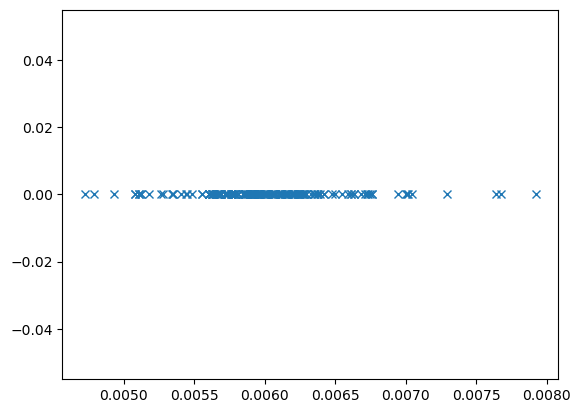

In [47]:
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.show()

And some description of the errors list is:

In [48]:
average_recon_error = np.mean(np.array(errors_list))  
stdev_recon_error = np.std(np.array(errors_list)) 
min_prob = np.min(errors_list)
max_prob = np.max(errors_list)

print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

The average of the errors list is:  0.006008613035815318
The standard deviation of the errors list is:  0.0004896240564495222
The min value of the errors list is:  0.004726247861981392
The max value of the errors list is:  0.007921401411294937


Having looked at the data points of the errors, the average and the standard deviation of it, we can map the errors to be a percentage probability in the following manner:

- 0.004726, which is the minimum error, can represent a 100% probability of predicting the image as a non-anomaly bottle.
- 0.007921, which is the maximum error, can represent a 60% probability of predicting the image as a non-anomaly bottle. 

The above conclusion is stated because we know we are working with only non-anomaly bottles. Hence, those error values correspond, all of them, to non-anomaly bottles; even the image that outputed the maximum error value must be predicted to be a non-anomaly bottle. 


Moreover, it would be interesting to see as well a plot of the error values of the images that are indeed anomaly bottles. Let's plot them.

In [49]:
errors_list_anomalies = []
for i in range(len(anomaly_file_paths)-1):
    error_value = output_error(anomalies_samples[0][i])
    errors_list_anomalies.append(error_value)  

1/1 [==============================] - 0s 39ms/step - loss: 0.0061 - mse: 0.0061


C:\Users\Alex\AppData\Local\Temp\ipykernel_19268\691926562.py:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0055 - mse: 0.0055


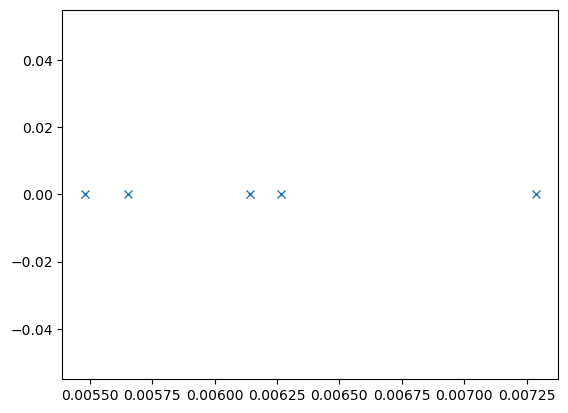

In [50]:
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list_anomalies, np.zeros_like(errors_list_anomalies) + val, 'x')
plt.show()

In [51]:
average_recon_error = np.mean(np.array(errors_list_anomalies))  
stdev_recon_error = np.std(np.array(errors_list_anomalies)) 
min_prob = np.min(errors_list_anomalies)
max_prob = np.max(errors_list_anomalies)

print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

The average of the errors list is:  0.006164940167218446
The standard deviation of the errors list is:  0.0006320776363051073
The min value of the errors list is:  0.005481232888996601
The max value of the errors list is:  0.0072860438376665115


Let's plot both of the errors values in the same figure.

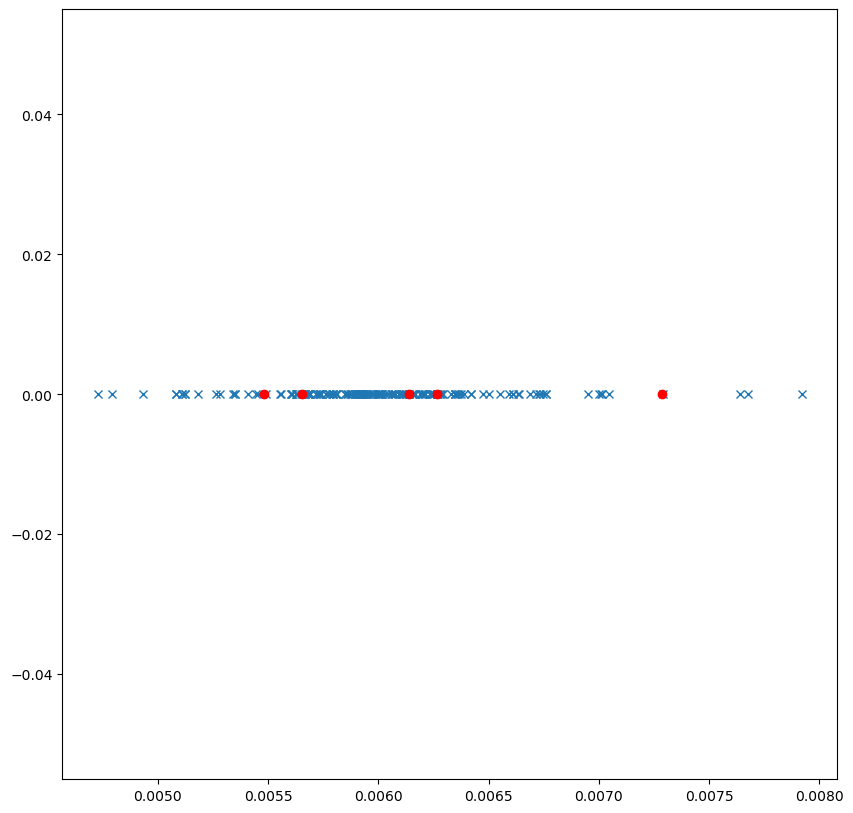

In [52]:
plt.figure(figsize=(10, 10))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.plot(errors_list_anomalies, np.zeros_like(errors_list_anomalies) + val, 'ro')
plt.show()

As we can see above, we have a problem. The error values of the anomaly bottles are mixed with the error values of the non-anomaly bottles. It is difficult to draw a line to divide these two categories. However, we can consider of focusing only in the part where most of the non-anomaly bottles error values lie on, that is, if an error value lies into the Guassian distribution of the non-anomaly errors distribution, then it will have more probability of being predicted as such. If the error value lies outside the Gaussian distribution, then the percentage of being detected as such should decrease.

Let's code some function that if:
- The error value is 0.006, which is exactly the average of the non-anomaly distribution, then it should have a 100% probability of being detected as such.
- The error value is 0.006 +/- 0.00049 then the probability of being detected as a non-anomaly bottle is 0%.

The above data is based on the Gaussian distribution of the non-anomaly bottles errors. 

In [81]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [83]:
def map_error2prob(value):
    # Calculate the mean and standard deviation
    mean = 0.006
    std_dev = 0.00049
    aux_score = abs(value - mean)
    if aux_score > 0.00049:
        aux_score = 0.00049
    prob_score = ranges_mapper(aux_score, 0, std_dev, 100,0)
    return prob_score

In [84]:
print(map_error2prob(0.0075))

0.0


In [78]:
0.006/3

0.002

## Using the anomalies samples set. All images are ANOMALIES bottles

In [56]:
anomalies_samples

(['C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Anomalies\\Anomalies_samples\\img1.jpg',
  'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Anomalies\\Anomalies_samples\\img2.jpg',
  'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Anomalies\\Anomalies_samples\\img3.jpg',
  'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Anomalies\\Anomalies_samples\\img4.jpg',
  'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Anomalies\\Anomalies_samples\\img5.jpg',
  'C:\\Users\\Alex\\Documents\\BottleStoodUp_atNight\\Anomalies\\Anomalies_samples\\img6.jpg'],
 array([1., 1., 1., 1., 1., 1.]))

In [207]:
predictions_list = [] 
labels_list = [] 
for i in range(len(anomaly_file_paths)-1):
    model_prediction = predict_label(anomalies_samples[0][i])
    model_label = int(anomalies_samples[1][i])
    predictions_list.append(model_prediction)  
    labels_list.append(model_label)

1/1 [==============================] - ETA: 0s - loss: 0.0061 - mse: 0.0061

C:\Users\Alex\AppData\Local\Temp\ipykernel_21828\2248361421.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0055 - mse: 0.0055


In [208]:
print(predictions_list)

[1, 1, 0, 1, 0]


### The Precision metric

In [59]:
pre = Precision()

In [60]:
pre.reset_state()
pre.update_state(labels_list, predictions_list)
pre.result().numpy()

1.0

In [61]:
print("This is the ground truth list: ", labels_list)
print("This is the prediction list: ", predictions_list)

This is the ground truth list:  [1, 1, 1, 1, 1]
This is the prediction list:  [1, 1, 0, 1, 0]


See that from all the elements that the model has predicted to be positive, all of them are correct, that is why the precision value of this model is 100%.

### The Recall metric

In [209]:
re = Recall()

In [210]:
re.reset_state()
re.update_state(labels_list, predictions_list)
re.result().numpy()

0.6

In [211]:
print("This is the ground truth list: ", labels_list)
print("This is the prediction list: ", predictions_list)

This is the ground truth list:  [1, 1, 1, 1, 1]
This is the prediction list:  [1, 1, 0, 1, 0]


See that because of the two false negatives, the recall value becomes:

recall = 3 / (3+2) = 0.6

### The Specificity metric

In [212]:
tn, fp, fn, tp = confusion_matrix(labels_list, predictions_list).ravel()
specificity_val = tn/(tn+fp)
if(math.isnan(specificity_val)):
    specificity_val = 0
print("The specificity value is: ", specificity_val)

The specificity value is:  0


C:\Users\Alex\AppData\Local\Temp\ipykernel_21828\90122747.py:2: RuntimeWarning: invalid value encountered in longlong_scalars
  specificity_val = tn/(tn+fp)


The model has 0% of specificity metric detection. This makes sense since in the dataset there does not exist any bottle without anomaly, i.e. no true negative value could be included for the computation. In this kind of dataset, a better metric to look at is the recall metric.

### The Accuracy metric

In [213]:
acc = BinaryAccuracy()

In [214]:
acc.reset_state()
acc.update_state(labels_list, predictions_list)
acc.result().numpy()

0.6

It outputs a 60% of accuracy.

### The Confusion Matrix

Having the predicted and true labels we can generate the confustion matrix. 

In [215]:

# result = confusion_matrix(labels_list, predictions_list,normalize='pred') #Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(labels_list, predictions_list)
print(result)

[[0 0]
 [2 3]]


Now, to plot the confusion matrix in a very comprehensive way, we use:

Text(0.5, 23.52222222222222, 'Predicted label')

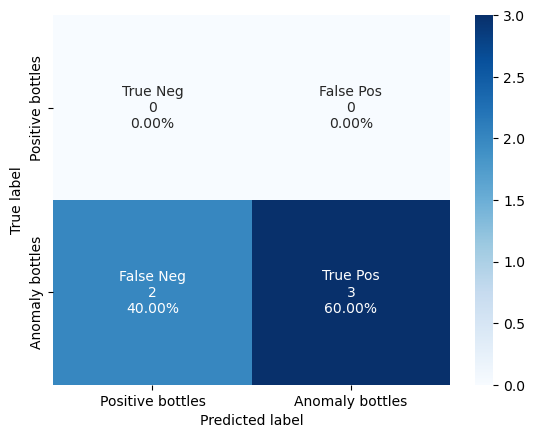

In [216]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     result.flatten()/np.sum(result)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]          #To print the group names as well 
# labels = [f"{v1}\n{v2}" for v1, v2 in
#           zip(group_counts,group_percentages)]                    #For printing without the group names labels                    

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(result, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

From above, we can see that the model correctly classifies the anomaly bottles (3 true positives). On the other hand, the classifications for bottles without anomalies, the model incorrectly classifies 2 of them; it classifies as bottles without anomalies where in reality these are bottles with anomalies.

# Working on the latent space of the model

This is a different approach of setting a threshold and detecting an anomaly. Instead of working directly with the error metric at the end of the model, it will be reached until the latent space of the model and in here a threshold value will be selected.

Let us extract (or build) the encoder network, with trained weights.

This is used to get the compressed output (latent space) of the input image. 

The compressed output is then used to calculate the KDE

In [19]:
encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)      

NOtice that the new model: "encoder_model" is the same as "model" but without considering the decoder part of it, only the encoder part. 

It is now time to use this new model. This will generate a feature vector or also called by the video source of this notebook, the latent vector.

In [20]:
########################################################
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict_generator(train_generator)

C:\Users\Alex\AppData\Local\Temp\ipykernel_8136\454703430.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  encoded_images = encoder_model.predict_generator(train_generator)


In [21]:
print(encoded_images.shape)

(13704, 16, 16, 16)


See that it is 13704 length because it corresponds to all the images that belong to the training dataset. Also the shape of the representation of the original images has been lowered to (16, 16, 16) as specified in the model structure. 
 

In [22]:
type(encoded_images)

numpy.ndarray

Now we will flatten the encoder output because KDE from sklearn takes 1D vectors as input

First we print the output shape of the encoder model

In [23]:
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
print(encoder_output_shape)

(None, 16, 16, 16)


Then we flatten the output of the enconded images in order for it to be (13704, 16 * 16 * 16)

In [24]:
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]
encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]


In [25]:
len(encoded_images_vector)

13704

In [26]:
encoded_images_vector[0].shape

(4096,)

Now, let's fit KDE to the image latent data


In [27]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

The above function fits a kernel density estimation to the data that is provided, that is, the "encoded_images_vector" variable. It does so using a Guassian kernel of bandwidth 0.2.

The badnwidth parameter affects on how the selected kernel will fit each sample of the given data. For example for the case in which the kernel is a Gaussian distribution, the bandwidth parameter would affect in how thin or wide is the Gaussian distribution.

At this point in the variable "kde" we have some numbers that are the result of fitting Gaussian functions to the given data points in the variable "encoded_images_vecotr". We will use the "kde" variable later for scoring with it, some given data points; the scoring will be given depending on how similar are the given data points to the ones that it had estimated.

In [30]:
#Calculate density and reconstruction error to find their means values for
#good and anomaly images. 
#We use these mean and sigma to set thresholds. 
def calc_density_and_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_density, stdev_density, average_recon_error, stdev_recon_error

The function above, given a batch of images, does:
- Encodes a single image.
- Flattens the encoded image.
- Assign a density score of the flattened image using the previously computed "kde" variable.
- Computes a reconstruction error of the image. For this it uses the complete neural network model, the one that was created at the beginning. 
- Appends in two lists:
    - The reconstruction error.
    - The density score of the encoded model result.
- At the end, based on the density and reconstruction error, the funtion otuputs the mean and standard deviation of both metrics.

In [31]:
#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images. 
#For this let us generate a batch of images for each. 
train_batch = train_generator.next()[0]     # This is the uninfected images
anomaly_batch = anomaly_generator.next()[0] # This is the parasitized images

uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)



1/1 [==============================] - 0s 37ms/step - loss: 0.0058 - mse: 0.0058


See that "uninfected_values" and "anomaly_values" have length of four and contain the average_density, stdev_density, average_recon_error, stdev_recon_error

In [35]:
print(uninfected_values)
print(anomaly_values)

(2818.7600142837364, 7.087883489561854e-12, 0.005494946303466956, 0.0009135791106844122)
(1635.4463236000852, 1167.4125009720128, 0.0068234895755137715, 0.0013553442590894956)


In [56]:
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    density_threshold = 2500 #Set this value based on the above exercise
    reconstruction_error_threshold = 0.006 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")
      

In [43]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
para_file_paths = glob.glob(r'C:\Users\Alex\Documents\TFM_project\cellsDataset\cell_images\parasitized1\Parasitized\*')
uninfected_file_paths = glob.glob(r'C:\Users\Alex\Documents\TFM_project\cellsDataset\cell_images\uninfected1\Uninfected\*')

1/1 [==============================] - 0s 30ms/step


C:\Users\Alex\AppData\Local\Temp\ipykernel_8136\349380335.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0056 - mse: 0.0056
The image is an anomaly


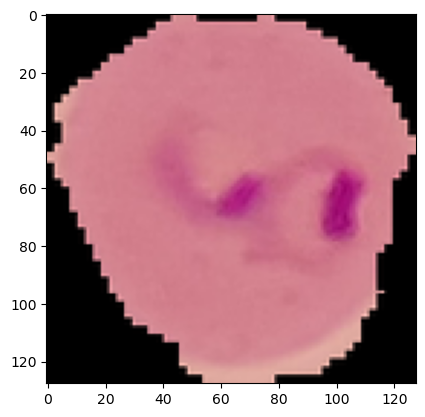

In [45]:
#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])

1/1 [==============================] - 0s 32ms/step


C:\Users\Alex\AppData\Local\Temp\ipykernel_8136\3669532084.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0059 - mse: 0.0059
The image is NOT an anomaly


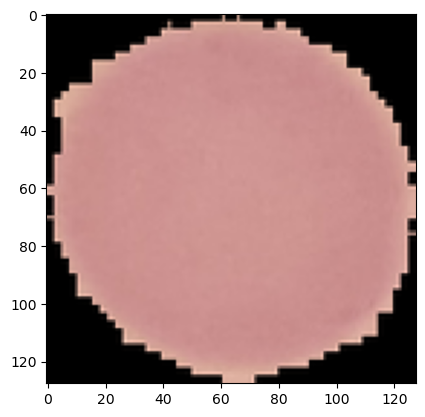

In [57]:
#Good/normal image verification
num=random.randint(0,len(uninfected_file_paths)-1)
check_anomaly(uninfected_file_paths[num])